# Benchmark comparison of protein sequence preprocessing effect on learning task for Pfam family classification

Notebook below allows to play with parameters of the workflow and yield different results.
As a default state it is set with parameters described in the paper as well as used as a base for plots.

In [16]:
import os

import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, interactive, interact_manual, fixed
import sys
from urllib import request
from scripts.data_preparation_support import data_preparation, split_to_train_test
from scripts.shorten_encoding import compress_protein_data_original, compress_protein_data_singletons, compress_protein_data_triplets
from scripts.prepare_vectors import split_data_to_classes, prepare_biovec_model, load_biovec_model_with_classes
from scripts.prepare_input_stats import input_analysis
from scripts.model_scripts.decision_trees import decision_tree_func
from scripts.model_scripts.random_tree import random_tree_func
from scripts.model_scripts.mlp import mlp_func
from scripts.model_scripts.nearest_neighbours import nearest_neighbours_func
from scripts.model_scripts.deep_learning import deep_learning_func
from scripts.plotting_support import results_plot_benchmark, plot_sizes
from time import time

## Dataset
In this project I provide already prepared - cleaned dataset used for the report, so download part below is commented out. However if desired, parameters can be tweaked to obtain altered version.

Raw data for this project is easily accessible by the Swissprot part of the Uniprot Database.
Unfortunately, full file weights around 250Mb, so instead I provide link for download.

In case server can't handle the download through Python, it is still possiblle to download tab-separated file directly
from the website: [LINK](https://www.uniprot.org/uniprot/?query=reviewed%3Ayes&columns=id%2Cdatabase(Pfam)%2Corganism%2Csequence)

It suggested, although not neccessary, to put downloaded file into ./data/full directory for clarity and ease of use of the default values below.

In [7]:
# url="https://www.uniprot.org/uniprot/?query=reviewed:yes&format=tab&columns=id,database(Pfam),organism,sequence"
# request.urlretrieve(url, "./data/full/uniprot-reviewed_yes.tab")

In [8]:
def data_prepare_widget():
    org_w = widgets.BoundedIntText(value=1000, min=1, max=5000, step=1, description="Organisms")
    fam_w = widgets.BoundedIntText(value=20, min=1, max=200, step=1, description="Families")
    infile = widgets.Text(value="./data/full/uniprot-reviewed_yes.tab",  description="Input path")
    outfile = widgets.Text(value="./data/data_file.fasta", description="Output path")

    widget = interact_manual.options(manual_name="Prepare data")
    widget(data_preparation, n_org=org_w, n_fam=fam_w, file_path=infile, outfile_path=outfile)

In [9]:
data_prepare_widget()

interactive(children=(Text(value='./data/full/uniprot-reviewed_yes.tab', description='Input path'), Text(value…

At this point of code raw Swissprot data was filtered by the top number of organisms and picked proteins containing single domain from top biggest families.

However, before splitting our data to train and test, we want to first adress very simmilar sequences.
It can be done using CD-HIT package.

In [10]:
def run_cdhit(input_f="./data/to_cluster/data_file.fasta", output_f="./data/to_cluster/data_file_outttt.fasta", c="0.99"):
    c = str(c)
    print("Begin CD-HIT")
    os.system(f"./CD-HIT/cd-hit -i {input_f} -o {output_f} -c {c}")


def run_cdhit_widget():
    c = widgets.BoundedFloatText(value=0.99, min=0.7, max=1, description="Simmilarity")
    infile = widgets.Text(value="./data/data_file.fasta",  description="Input path")
    outfile = widgets.Text(value="./data/clustering/data_file_clustered.fasta", description="Output path")

    widget = interact_manual.options(manual_name="Prepare data")
    widget(run_cdhit, c=c, input_f=infile, output_f=outfile)

In [11]:
run_cdhit_widget()

interactive(children=(Text(value='./data/data_file.fasta', description='Input path'), Text(value='./data/clust…

Now our data is cleaned out and ready to process.

## Data processing

For this project data is processed in multiple ways.

 - Standard single-letter encoding
 - Conversion into numbers and using int-8 encoding
 - Conversion into 3-mers, encoding each 3-mer as a number and using int-16 encoding
 - Using Biovec vector encoder

First we need to split our data into training and test parts.
To avoid dominance of the biggest families, training data will contain the same number of sequences for each PFAM family.

### Warning!
Please analyse the histogram first before providing number of sequences per family to train.
Families with number of representatives lower than provided will be filtered out!

Sometimes it might be beneficial to filter out couple families with low coverage.

In [12]:
def histogram_widget():
    infile = widgets.Text(value="./data/clustering/data_file_clustered.fasta",  description="Input path")
    widget = interact_manual.options(manual_name="Prepare histogram")

    widget(input_analysis, input_file=infile)

In [13]:
histogram_widget()

interactive(children=(Text(value='./data/clustering/data_file_clustered.fasta', description='Input path'), But…

In [14]:
def split_to_train_test_widget():
    train_val = widgets.BoundedIntText(value=650, min=1, max=5000, step=1, description="N. to train")
    infile = widgets.Text(value="./data/clustering/data_file_clustered.fasta",  description="Input path")
    outfile = widgets.Text(value="./data/clean_dataset.pkl", description="Output path")

    widget = interact_manual.options(manual_name="Prepare data")
    new_val = widget(split_to_train_test, train_val=train_val, infile=infile, outfile=outfile)
    return new_val

In [15]:
train_val_global = split_to_train_test_widget()

interactive(children=(BoundedIntText(value=650, description='N. to train', max=5000, min=1), Text(value='./dat…

This process will save data into convenient pickle object. This way instead of keeping 4 separate files or trying to split our data in one file we can easily load a list prepared to use.

In [16]:
compress_protein_data_original(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_original.pkl')

In [17]:
compress_protein_data_singletons(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_singletons.pkl')

In [18]:
compress_protein_data_triplets(infile='./data/clean_dataset.pkl', outfile='./data/clean_dataset_triplets.pkl')

## Biovec

Biovec model is built on top of the original implementation, thus data handling must be a bit different, to fit authors requirements.
Sequences must be split into class fasta files, and one combined with identical names.
Combined file will be used to generate model, wchich will be then saved.
This saved model, is next loaded again, but this time, we also provide family information.

After this procedure we are finally left with a data ready to split into training and test, perform learning and predictions.


### Warning !
This time widget is not provided, because of the ./data/vectors/combined_corpus.fasta file.
If Biovec recognizes this file it will skip creating a new model.
That's why paths here are fixed to ensure, old corpus file is deleted.

### Warning !
It might happen, that during loading process there will be information, that model did not train on certain triplets.
It is connected with fragments containing extended alphabet like "X" and are ignored.

In [19]:
split_data_to_classes(infile="./data/clean_dataset.pkl", output_folder="./data/vectors/class_folder",
                          output_combined_file="./data/vectors/combined.fasta")

In [20]:
prepare_biovec_model(infile="./data/vectors/combined.fasta", outfile="./data/vectors/ProtVec_model.model")

In [21]:
def load_biovec_widget():
    train_val = widgets.BoundedIntText(value=650, min=1, max=5000, step=1, description="N. to train")

    widget = interact_manual.options(manual_name="Prepare data")

    new_val = widget(load_biovec_model_with_classes, train_size=train_val, input_model=fixed("./data/vectors/ProtVec_model.model"), class_folder=fixed("./data/vectors/class_folder"), outfile=fixed('./data/clean_dataset_biovec.pkl'))

In [22]:
load_biovec_widget()

interactive(children=(BoundedIntText(value=650, description='N. to train', max=5000, min=1), Button(descriptio…

## Evaluation

Now, that we have all data prepared, we can evaluate them both in accuracy and runtime.

Several models will be created - please note, that not all of them are equally suitable for this kind of data - the point is in efficiency comparison.

- Decision trees
- Random trees
- Nearest Neighbours
- MLP
- Simple Machine Learning with Dense layers

In [2]:
all_times = []
all_accs = []

In [3]:
s1 = time()
acc1 = decision_tree_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = decision_tree_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = decision_tree_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = decision_tree_func("./data/clean_dataset_biovec.pkl")
t4 = time() - s4

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)

all_times.append([t1, t2, t3, t4])
all_accs.append([acc1, acc2, acc3, acc4])

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 40
----- Model accuracy: 0.331
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 80
----- Model accuracy: 0.566
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 80
----- Model accuracy: 0.55
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best model:
- max_depth: 40
----- Model accuracy: 0.668


In [4]:
print(f"Statistic | Original | Singletons | Triplets | Biovec")
print(f"----------|----------|------------|----------|---------")
print(f"Time      | {t1} \t | {t2} \t | {t3} \t | {t4} \t")
print(f"Accuracy  | {acc1} \t | {acc2} \t | {acc3} \t | {acc4} \t")

Statistic | Original | Singletons | Triplets | Biovec
----------|----------|------------|----------|---------
Time      | 16.67 	 | 11.1 	 | 6.24 	 | 0.34 	
Accuracy  | 0.3306 	 | 0.5661 	 | 0.55 	 | 0.668 	


In [5]:
s1 = time()
acc1 = random_tree_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = random_tree_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = random_tree_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = random_tree_func("./data/clean_dataset_biovec.pkl")
t4 = time() - s4

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)

all_times.append([t1, t2, t3, t4])
all_accs.append([acc1, acc2, acc3, acc4])

Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 20
- max_features: 15
----- Model accuracy: 0.4
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 20
- max_features: 15
----- Model accuracy: 0.697
Fitting 2 folds for each of 15 candidates, totalling 30 fits
Best model:
- random_state: 1234
- max_depth: 20
- max_features: 15
----- Model accuracy: 0.673
Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV 2/2] END ......................max_depth=10;, score=0.518 total time=   0.8s
[CV 2/2] END ......................max_depth=20;, score=0.534 total time=   0.9s
[CV 2/2] END ......................max_depth=30;, score=0.518 total time=   1.0s
[CV 2/2] END ......................max_depth=40;, score=0.525 total time=   0.9s
[CV 2/2] END ......................max_depth=50;, score=0.529 total time=   0.9s
[CV 2/2] END ......................max_depth=60;, score=0.527 tot

/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best model:
- random_state: 1234
- max_depth: 10
- max_features: 10
----- Model accuracy: 0.862


In [6]:
print(f"Statistic | Original | Singletons | Triplets | Biovec")
print(f"----------|----------|------------|----------|---------")
print(f"Time      | {t1}\t | {t2}\t | {t3} \t | {t4} \t")
print(f"Accuracy  | {acc1}\t | {acc2}\t | {acc3} \t | {acc4} \t")

Statistic | Original | Singletons | Triplets | Biovec
----------|----------|------------|----------|---------
Time      | 26.0	 | 22.44	 | 24.26 	 | 5.97 	
Accuracy  | 0.4	 | 0.6968	 | 0.6726 	 | 0.8618 	


In [7]:
s1 = time()
acc1 = nearest_neighbours_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = nearest_neighbours_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = nearest_neighbours_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = nearest_neighbours_func("./data/clean_dataset_biovec.pkl")
t4 = time() - s4

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)

all_times.append([t1, t2, t3, t4])
all_accs.append([acc1, acc2, acc3, acc4])

Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.394
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.653
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.616
Best model:
- weights: distance
- algorithm: auto
----- Model accuracy: 0.83


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [8]:
print(f"Statistic | Original | Singletons | Triplets | Biovec")
print(f"----------|----------|------------|----------|---------")
print(f"Time      | {t1}\t | {t2}\t | {t3} \t | {t4} \t")
print(f"Accuracy  | {acc1}\t | {acc2}\t | {acc3} \t | {acc4} \t")

Statistic | Original | Singletons | Triplets | Biovec
----------|----------|------------|----------|---------
Time      | 8.03	 | 3.29	 | 1.63 	 | 0.22 	
Accuracy  | 0.3935	 | 0.6532	 | 0.6161 	 | 0.8302 	


In [9]:
s1 = time()
acc1 = mlp_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = mlp_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = mlp_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = mlp_func("./data/clean_dataset_biovec.pkl")
t4 = time() - s4

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)

all_times.append([t1, t2, t3, t4])
all_accs.append([acc1, acc2, acc3, acc4])

Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.381
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.656
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/m

Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.268
Fitting 2 folds for each of 3 candidates, totalling 6 fits


/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/benchmark_project_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/exsto/anaconda3/envs/b

Best model:
- hidden_layer_sizes: 128
- activation: relu
- solver: adam
----- Model accuracy: 0.792


In [10]:
print(f"Statistic | Original | Singletons | Triplets | Biovec")
print(f"----------|----------|------------|----------|---------")
print(f"Time      | {t1}\t | {t2}\t | {t3} \t | {t4} \t")
print(f"Accuracy  | {acc1}\t | {acc2}\t | {acc3} \t | {acc4} \t")

Statistic | Original | Singletons | Triplets | Biovec
----------|----------|------------|----------|---------
Time      | 199.47	 | 152.6	 | 52.42 	 | 1.94 	
Accuracy  | 0.3806	 | 0.6565	 | 0.2677 	 | 0.7917 	


In [11]:
s1 = time()
acc1 = deep_learning_func("./data/clean_dataset_original.pkl")
t1 = time() - s1

s2 = time()
acc2 = deep_learning_func("./data/clean_dataset_singletons.pkl")
t2 = time() - s2

s3 = time()
acc3 = deep_learning_func("./data/clean_dataset_triplets.pkl")
t3 = time() - s3

s4 = time()
acc4 = deep_learning_func("./data/clean_dataset_biovec.pkl")
t4 = time() - s4

t1 = round(t1, 2)
t2 = round(t2, 2)
t3 = round(t3, 2)
t4 = round(t4, 2)

all_times.append([t1, t2, t3, t4])
all_accs.append([acc1, acc2, acc3, acc4])

  0%|          | 0/9 [00:00<?, ?it/s]2022-06-12 19:33:43.858691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-12 19:33:43.858786: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-12 19:33:43.858862: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (exsto-Latitude-E5450): /proc/driver/nvidia/version does not exist
2022-06-12 19:33:43.859912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-12 19:33:44.826363: W tensorflow/core/framework/cpu_alloc

0.3870967626571655


2022-06-12 19:33:46.559526: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74009600 exceeds 10% of free system memory.
 33%|███▎      | 3/9 [00:05<00:09,  1.63s/it]

0.39677420258522034


2022-06-12 19:33:49.245635: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 74009600 exceeds 10% of free system memory.
 56%|█████▌    | 5/9 [00:08<00:05,  1.50s/it]

0.4145161211490631


 67%|██████▋   | 6/9 [00:09<00:04,  1.49s/it]

0.4354838728904724


 52%|█████▏    | 14/27 [00:26<00:25,  1.98s/it]

0.4516128897666931


100%|██████████| 27/27 [00:50<00:00,  1.85s/it]


----- Model accuracy: 0.452


 11%|█         | 1/9 [00:01<00:09,  1.20s/it]

0.4145161211490631


 22%|██▏       | 2/9 [00:02<00:08,  1.21s/it]

0.4306451678276062


 33%|███▎      | 3/9 [00:03<00:07,  1.26s/it]

0.4725806415081024


 56%|█████▌    | 5/9 [00:07<00:05,  1.49s/it]

0.5048387050628662


100%|██████████| 27/27 [00:40<00:00,  1.49s/it]


----- Model accuracy: 0.505


 11%|█         | 1/9 [00:01<00:09,  1.17s/it]

0.10000000149011612


 22%|██▏       | 2/9 [00:02<00:07,  1.14s/it]

0.106451615691185


 56%|█████▌    | 5/9 [00:06<00:05,  1.43s/it]

0.2758064568042755


100%|██████████| 27/27 [00:38<00:00,  1.42s/it]


----- Model accuracy: 0.276


 11%|█         | 1/9 [00:00<00:07,  1.00it/s]

0.12842942774295807


 22%|██▏       | 2/9 [00:02<00:08,  1.18s/it]

0.1833001971244812


 33%|███▎      | 3/9 [00:03<00:06,  1.15s/it]

0.3667992055416107


 67%|██████▋   | 6/9 [00:06<00:03,  1.09s/it]

0.5184890627861023


 89%|████████▉ | 8/9 [00:09<00:01,  1.16s/it]

0.5212723612785339


100%|██████████| 9/9 [00:10<00:00,  1.15s/it]


0.5998011827468872


100%|██████████| 27/27 [00:31<00:00,  1.18s/it]

----- Model accuracy: 0.6


Statistic | Original | Singletons | Triplets | Biovec
----------|----------|------------|----------|---------
Time      | 67.14	 | 53.67	 | 50.93 	 | 42.39 	
Accuracy  | 0.4516128897666931	 | 0.5048387050628662	 | 0.2758064568042755 	 | 0.5998011827468872 	


[[16.67, 11.1, 6.24, 0.34], [26.0, 22.44, 24.26, 5.97], [8.03, 3.29, 1.63, 0.22], [199.47, 152.6, 52.42, 1.94], [67.14, 53.67, 50.93, 42.39]]
[[0.3306, 0.5661, 0.55, 0.668], [0.4, 0.6968, 0.6726, 0.8618], [0.3935, 0.6532, 0.6161, 0.8302], [0.3806, 0.6565, 0.2677, 0.7917], [0.4516128897666931, 0.5048387050628662, 0.2758064568042755, 0.5998011827468872]]


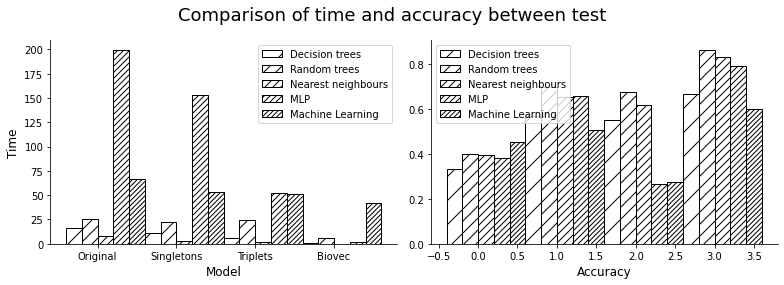

In [18]:
names = ["Original", "Singletons", "Triplets", "Biovec"]
tests = ["Decision trees", "Random trees", "Nearest neighbours", "MLP", "Machine Learning"]
print(all_times)
print(all_accs)
results_plot_benchmark(names, tests, all_times, all_accs)

In [13]:
plot_sizes(["./data/clean_dataset_original.pkl", "./data/clean_dataset_singletons.pkl",
                "./data/clean_dataset_triplets.pkl", "./data/clean_dataset_biovec.pkl"],
               ["Original", "Singletons", "Triplets", "Biovec"],
               "./presentation/images/sizes.png")